In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_quad_no_constraint import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
problem_spec['vector_size'] = 10
# problem_spec['vector_size'] = 50
problem_spec['sc_theta'] = 0.5
problem_spec['sc_perturb'] = True
problem_spec['sc_index_set'] = {0,1,2,3,4,5}
# problem_spec['sc_index_set'] = {3,4}
# problem_spec['sc_index_set'] = {}
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()
problem_data['itr_num'] = 1000


{'n_node': 6, 'vector_size': 10, 'sc_theta': 0.5, 'sc_perturb': True, 'sc_index_set': {0, 1, 2, 3, 4, 5}}


In [3]:
Q = problem_data['Q']
b = problem_data['b']
n_node = problem_spec['n_node']
vector_size = problem_spec['vector_size']
sc_index_set = problem_spec['sc_index_set']

for j in range(n_node):
    U, s, V = np.linalg.svd(Q[j])
    print([np.max(s), np.average(s), np.min(s)])

[2.22244360208879, 0.9614927485949888, 0.03776225093236773]
[2.797373714405503, 1.053305637300958, 0.0036908268624107872]
[4.475898105285475, 1.1459669089702413, 0.018770219533008947]
[4.806210985840071, 1.1454892970861046, 0.005851122480356822]
[2.8359765001002106, 0.8567381308275891, 0.03777071906243162]
[2.3239537103097625, 0.6608619104559805, 0.020410838550668137]


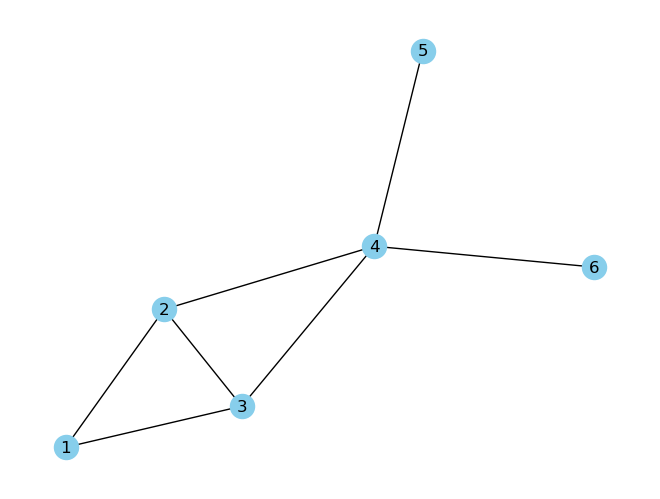

In [4]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
plt.savefig("plots/graph_n6.pdf")

In [5]:
f_star, x_opt_star = min_cvx_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-0.0029070664889455427, np.linalg.norm(x_opt_star)=0.0390010435054993


In [6]:
f_star, x_opt_star = min_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-0.0029070664889455427, np.linalg.norm(x_opt_star)=0.0390010435054993


In [7]:
Q = problem_data['Q']
b = problem_data['b']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
prox_operators = []
fi_operators = []

# Define functions and proximal operators to implement the method
for jj in range(n_node):
    Qj = Q[jj]
    bj = b[jj]
    # prox_operators += [lambda z, rho: cvx_prox_fj_quad_no_constraint(z, rho, problem_spec, problem_data, jj) ]
    prox_operators += [lambda z, rho, Qj=Qj, bj=bj, vector_size=vector_size : prox_fj_quad_no_constraint(z, rho, Qj, bj, vector_size) ]
    fi_operators += [lambda x_kj, Qj=Qj, bj=bj : 1/2 * x_kj @ Qj @ x_kj.T + np.dot(bj[0], x_kj) ]

    c = np.random.randn(vector_size)
    x1 = prox_operators[-1](c, 1/5)
    x2 = cvx_prox_fj_quad_no_constraint(c, 1/5, problem_spec, problem_data, jj, eps=1e-4)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

In [8]:
# problem_data['rho'] = 1
# params={"R":1, "Capacitance":1, "h":0.561455037879421}

# pg_c_op_norm, pg_c_err_opt_star, pg_c_err_opt_reldiff, pg_c_const_vio, pg_c_f_reldiff = co.pg_extra("pg_extra_c", problem_spec, problem_data, 
#                                                                         network_data, x_opt_star, f_star, prox_operators=prox_operators,
#                                                                         fi_operators=fi_operators,
#                                                                         params=params, printing=True, sc_index_set = sc_index_set, freq=200)

In [9]:
# apply P-EXTRA 
best_rho = 1
find_best = True

# problem_data['rho'] = 0.01
# problem_data['rho'] = 0.1
# problem_data['rho'] = 0.2
# problem_data['rho'] = 0.5

# start = 0.2
start = 0.1
end = 2
space = 0.1

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        problem_data['rho'] = round(r, 2)
        # print("Testing rho :", r)
        pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        printing=False, freq=200)
        # new_val = sum(pg_f_reldiff[-10:]) / 10
        # new_val = sum(pg_f_reldiff[-300:]) / 300
        # new_val = sum(pg_f_reldiff[-300:-200]) / 100
        new_val = sum(pg_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_rho :", round(r, 2),  "new best_value :", new_val)
            best_value = new_val
            best_rho = round(r, 2)

print("best_rho :",best_rho)

new best_rho : 0.1 new best_value : 9.765108521054144e-10
new best_rho : 0.2 new best_value : 7.302480253487754e-12
new best_rho : 0.3 new best_value : 1.7702591396044362e-12
new best_rho : 0.4 new best_value : 6.741069563341564e-13
new best_rho : 0.5 new best_value : 6.256109974598982e-13
new best_rho : 0.6 new best_value : 5.604410096592966e-13
best_rho : 0.6


In [10]:
problem_data['rho'] = best_rho
# problem_data['rho'] = 1


# pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_quad_no_constraint(problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        printing=True, freq=200)

ii=0, f_reldiff[-1]=0.3128773657478983, err_opt_reldiff[-1]=0.5790194439025571
ii=200, f_reldiff[-1]=9.117007843406775e-09, err_opt_reldiff[-1]=3.35665354913859e-08
ii=400, f_reldiff[-1]=2.2377242005471334e-15, err_opt_reldiff[-1]=1.2159752073444726e-14
ii=600, f_reldiff[-1]=1.0442712935886622e-15, err_opt_reldiff[-1]=1.243571901706274e-14
ii=800, f_reldiff[-1]=8.950896802188533e-16, err_opt_reldiff[-1]=1.4944840158273307e-14
ii=999, f_reldiff[-1]=5.967264534792356e-16, err_opt_reldiff[-1]=1.7418238067692437e-14


In [11]:
best_R = 1
find_best = True

# R = 18
start = 0.2
end = 4
space = 0.2
# end = 2
# space = 0.1

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        R = round(r, 2)
        # print("Testing R :", r)
        admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=False, freq=200)
        # new_val = sum(admm_f_reldiff[-10:]) / 10
        # new_val = sum(admm_f_reldiff[-300:]) / 300
        # new_val = sum(admm_f_reldiff[-300:-200]) / 100
        new_val = sum(admm_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_R :", round(r, 2),  ", new best_value :", new_val)
            best_value = new_val
            best_R = round(r, 2)

print("best_R :", best_R)

new best_R : 0.2 , new best_value : 2.6710927564992344e-09
new best_R : 0.4 , new best_value : 1.0747043427161027e-14
new best_R : 0.6 , new best_value : 1.9542791351444964e-16
new best_R : 1.0 , new best_value : 1.9095246511335515e-16
best_R : 1.0


In [12]:
R = best_R
# R = 3
# R = 2
# R = 1
# R = 0.5
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        params={"R":R}, printing=True, freq=200)


ii=0, f_reldiff[-1]=1.3616068652749476
ii=200, f_reldiff[-1]=1.491816133698089e-16
ii=400, f_reldiff[-1]=1.491816133698089e-16
ii=600, f_reldiff[-1]=1.491816133698089e-16
ii=800, f_reldiff[-1]=1.491816133698089e-16
ii=999, f_reldiff[-1]=1.491816133698089e-16


In [15]:
problem_data['rho'] = best_rho
# params={"R":1, "Capacitance":1, "h":0.561455037879421}
params={"R":best_rho, "Capacitance":1, "h":0.561455037879421}
# params={"R":best_rho, "Capacitance":0.1, "h":0.7}

# problem_data['rho'] = 0.0001
# params={"R":best_rho, "Capacitance":0.1, "h":0.7}



pg_c_op_norm, pg_c_err_opt_star, pg_c_err_opt_reldiff, pg_c_const_vio, pg_c_f_reldiff = co.pg_extra("pg_extra_c", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        params=params, printing=True, sc_index_set = sc_index_set, freq=200)

ii=0, f_reldiff[-1]=0.22194554327961005, err_opt_reldiff[-1]=0.44384399150104237
ii=200, f_reldiff[-1]=5.6151601812365e-06, err_opt_reldiff[-1]=4.044231607937921e-05
ii=400, f_reldiff[-1]=2.173473320666504e-09, err_opt_reldiff[-1]=1.9436320854309568e-08
ii=600, f_reldiff[-1]=5.83150926662583e-13, err_opt_reldiff[-1]=8.45256734627563e-12
ii=800, f_reldiff[-1]=0.0, err_opt_reldiff[-1]=7.613732466475998e-15
ii=999, f_reldiff[-1]=4.475448401094266e-16, err_opt_reldiff[-1]=1.9882912554647247e-16


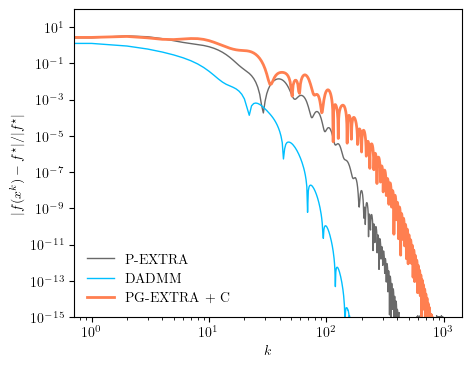

In [16]:
fname = "n6_qp_circuit_pg_c"

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 4
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["mathtext.fontset"] = 'cm' # default = 'dejavusans', other options = 'cm', 'stixsans', 'dejavuserif'
black, red, blue, green = 'dimgrey', 'coral', 'deepskyblue', 'green'

# operator norm plot (log-log plot)
plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_f_reldiff, label='P-EXTRA', color=black, linewidth=1)
plt.plot(admm_f_reldiff, label='DADMM', color=blue, linewidth=1)
# plt.plot(dadmm_c_all_f_reldiff, label='Circuit DADMM + C-All',  color=green, linewidth=1)
# plt.plot(dadmm_c_f_reldiff, label='Circuit DADMM + C',  color=red, linewidth=2)
plt.plot(pg_c_f_reldiff, label='PG-EXTRA + C',  color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$|f(x^k) - f^\star|/|f^\star|$")
# plt.ylabel(r"$\|\tilde{\mathbf{A}}x_k\|^2_M$")
plt.ylim(1e-15, 1e+2)
# plt.autoscale(enable=True, axis='y', tight=None)
plt.legend()
plt.savefig(f'plots/freldif_{fname}.pdf', dpi=300)